# Исследование интернет-магазина компьютерных игр

В исследуемом датасете содержатся исторические данные о продажах игр в нескольких регионах, оценки пользователей и экспертов, жанры и игровые платформы.

В процессе исследования произведен анализ продаж игр в зависимости от различных показателей, таких как игровые платформы, жанры игры, возрастной рейтинг. Выявлены, какие из этих параметров наиболее популярны последние годы. Выявлены закономерности, определяющие успешность игры для планировании рекламных компаний. Составлены портреты пользователей нескольких регионов (Северная Америка, Европа и Япония).

### Открытие и изучение датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
from scipy import stats as st
import shutil
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')

In [3]:
# Изучение кол-ва и тип данных в столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# Проверяем, что все корректно отображается в датасете
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Предобработка данных

In [5]:
# Проверка данных на дубликаты
df.duplicated().sum()

0

#### Приведение названия столбцов к нижнему регистру.

In [6]:
df.columns = df.columns.str.lower()

#### Обработка пропусков

In [7]:
# Кол-во прорущенных значений в столбцах
pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')

,0
name,2
platform,0
year_of_release,269
genre,2
na_sales,0
eu_sales,0
jp_sales,0
other_sales,0
critic_score,8578
user_score,6701


Проверим строчки с пропусками в столбце имени.

In [8]:
df.query('name.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Половина данных в них пусты, для исследования они не годятся. Удаляем

In [9]:
df = df.query('name.notnull()')

Пропусков в годе релиза также удаляем, количество таких строк 1,6% от датасета.

In [10]:
df = df.query('year_of_release.notnull()')

# Проверяем, что не удалили ничего лишнего
df.shape

(16444, 11)

Посмотрим на уникальные значения столбца rating

In [11]:
df['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Данный столбец содержит информацию о возрастном рейтинге игры. При этом 4 оценки сильно выделяются малым количеством данных. Ниже представлено объясление буквенных значений:

* EC - Для детей младшего возраста. Подходит для детей от 3 лет, неприемлемое содержание отсутствует.
* E - Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика.
* E 10+ - Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей.
* T - Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия.
* M - Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков.
* AO - Подходит для взрослых старше 18 лет. Классификация «для взрослых» используется, когда в игре присутствует крайний уровень насилия и немотивированного убийства. Также может присутствовать романтизация наркотиков, азартных игр и сексуальной активности.
* RP - Категория ещё не присвоена. Играм с категорией RP еще не присвоен окончательный рейтинг ESRB.

Рейтинг K-A - это старое название рейтинга E, использовался в старых играх. Переименуем его, чтобы не было путаницы.
RP - отсутствие рейтинга, залетело в данные вероятно по ошибке. Избавимся от нее и остальных рейтингах, которые встречаются редко (ЕС и АО).

Также следует учесть, что организация Entertainment Software Rating Board (ESRB) определяет рейтинг для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. Пропуски в ней вероятно указывают на то, что игра была выпущена не в этих странах и ей не присваивался рейтинг ESRB, либо игра вышла до 1994 года (года появления ESRB).

Чтобы включить в анализ игры без рейтинга ESRB, заменим все пропущенные значения на заглушку - 'no_rating'

In [12]:
# Заменяем рейтинг K-A
df['rating'] = df['rating'].replace('K-A', 'E')

# Удаляем рейтинги, которые встречаются редко
df = df.query('rating not in ["RP", "AO", "EC"]')

# Заменяем пропущенные значения
df['rating'] = df['rating'].fillna('no_rating')

# Проверка
df['rating'].value_counts()

no_rating    6676
E            3924
T            2905
M            1536
E10+         1393
Name: rating, dtype: int64

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Молодец! Сделали замену устаревшего рейтинга. 👍</font>

In [13]:
# Проверяем уникальные значения 'critic_score'
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [14]:
# Проверяем уникальные значения 'user_score'
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце user_score встречается значение tbd. Это аббревиатура переводится как to be decided or to be determined и означает, что у игры еще не определена оценка. Удалим это значение, оставив пропуск, чтобы они не мешали математическим операциям в дальнейшем.

In [15]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

Пропуски в столбцах 'critic_score' , 'user_score' могли произойти по нескольким причинам:
* ошибка в данных;
* игра была выпущена давно, до того как им стали присваиваться оценки;
* игра вышла недавно, оценка еще не была проставлена;

В любом случае, заполнить пропуски в этих столбцах не представляется возможным.

#### Изменение типов данных в столбцах

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16434 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16434 non-null  object 
 1   platform         16434 non-null  object 
 2   year_of_release  16434 non-null  float64
 3   genre            16434 non-null  object 
 4   na_sales         16434 non-null  float64
 5   eu_sales         16434 non-null  float64
 6   jp_sales         16434 non-null  float64
 7   other_sales      16434 non-null  float64
 8   critic_score     7981 non-null   float64
 9   user_score       7460 non-null   object 
 10  rating           16434 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Заменяем следующие столбцы:
* year_of_release - меняем на целое число, ведь столбец содержит год;
* critic_score - содержит в себе целое число от 0 до 100, приведем к int;
* user_score - содержит рейтинг от 0 до 10, приведем к float;

In [17]:
# Приводим год релиза к целому числу
df['year_of_release'] = df['year_of_release'].astype('int')

# Привеодим оценку критиков к целому числу
df['critic_score'] = df['critic_score'].astype('Int32')

# Приводим оценку пользователей к числу
df['user_score'] = pd.to_numeric(df['user_score'])

# Проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16434 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16434 non-null  object 
 1   platform         16434 non-null  object 
 2   year_of_release  16434 non-null  int32  
 3   genre            16434 non-null  object 
 4   na_sales         16434 non-null  float64
 5   eu_sales         16434 non-null  float64
 6   jp_sales         16434 non-null  float64
 7   other_sales      16434 non-null  float64
 8   critic_score     7981 non-null   Int32  
 9   user_score       7460 non-null   float64
 10  rating           16434 non-null  object 
dtypes: Int32(1), float64(5), int32(1), object(4)
memory usage: 1.4+ MB


#### Добавление столбца с суммарными продажами

In [18]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [19]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16434 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16434 non-null  object 
 1   platform         16434 non-null  object 
 2   year_of_release  16434 non-null  int32  
 3   genre            16434 non-null  object 
 4   na_sales         16434 non-null  float64
 5   eu_sales         16434 non-null  float64
 6   jp_sales         16434 non-null  float64
 7   other_sales      16434 non-null  float64
 8   critic_score     7981 non-null   Int32  
 9   user_score       7460 non-null   float64
 10  rating           16434 non-null  object 
 11  total_sales      16434 non-null  float64
dtypes: Int32(1), float64(6), int32(1), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en co

### Исследовательский анализ данных

#### Анализ количества игр в разные годы

Посмотрим, сколько игр выпускалось в разные годы.

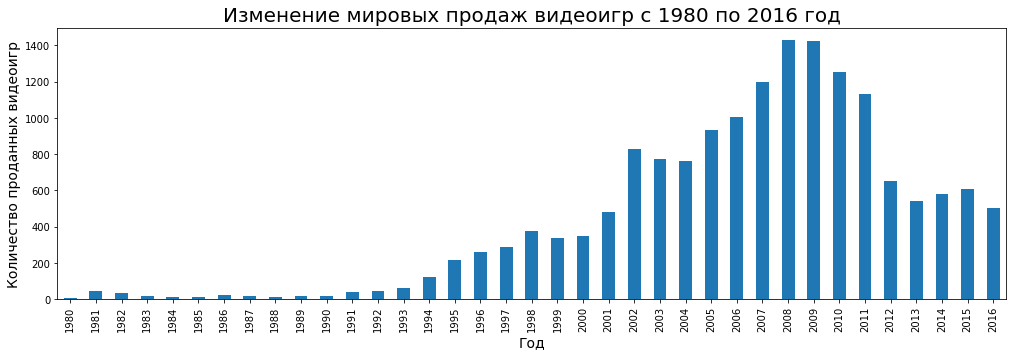

In [20]:
df.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar', figsize=(17,5), legend=False)

# Настройки диаграммы
plt.title('Изменение мировых продаж видеоигр с 1980 по 2016 год', fontsize=20)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество проданных видеоигр', fontsize=14)
plt.show();

На графике хорошо видно резкое увеличение числа видеоигр с 2002 года. Не зря 21 век зовется веком цифровых технологий! Далее с 2012 года количество проданных игр сходит с пика и идут ровнее. С учетом того, что такая сфера, как игровая индустрия, меняется очень быстро под влиянием множества факторов, для прогнозов на 2017 год лучше всего будет взять небольшой ровный период 2012-2016 гг.

In [21]:
# Запишем актуальный период в новую переменную
df_actual = df.query('year_of_release >= 2012')

#### Анализ продаж по игровым платформам

Посмотрим суммарные продажи по платформам.

Text(0, 0.5, 'Проданные копии, млн шт')

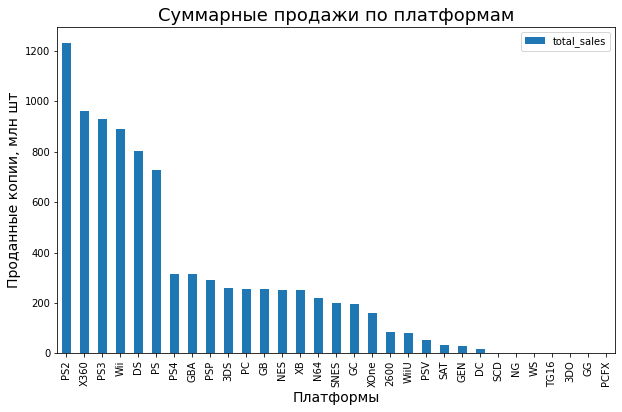

In [22]:
# Сгрупирруем и посмотрим суммарные продажи по платформам
df.groupby('platform').agg({'total_sales':'sum'})\
.sort_values(by='total_sales', ascending=False)\
.plot(kind='bar', figsize=(10,6))

# настройки графика
plt.title('Суммарные продажи по платформам', fontsize=18)
plt.xlabel('Платформы', fontsize=14)
plt.ylabel('Проданные копии, млн шт', fontsize=14)

Платформы с самыми высокими суммарными продажами запишем в отдельную переменную top_platforms. Выведем распределение продаж самых популярных платформ по годам.

In [23]:
top_platforms = df.groupby('platform').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False).head(6)

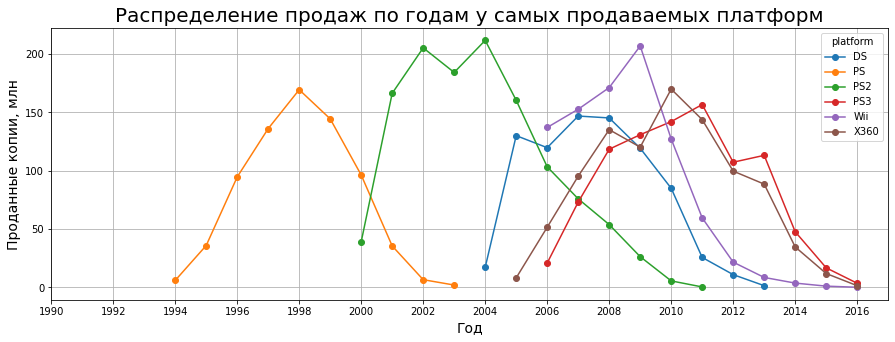

In [24]:
# Строим график по топ-6 платформ по суммарным продажам
df.query('platform in @top_platforms.index')\
.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')\
.plot(style='o-', figsize=(15,5), grid=True)

# Настройки графика
plt.title('Распределение продаж по годам у самых продаваемых платформ', fontsize=20)
plt.xlim(1990,2016+1)
plt.xticks(np.arange(1990, 2016+1, 2))
plt.xlabel('Год', fontsize=14)
plt.ylabel('Проданные копии, млн', fontsize=14)
plt.show();

На графике отчетливо видно, что в среднем любая консоль "живет" около 10 лет. При появлении новых моделей (даже того же производителя) их продажи падают, затем их полностью заменяют современные модели. Особенно это отчетливо заметно с консолями компании Sony, выпускающие новые модели каждые 5 лет (PS, PS2, PS3). Еще один вывод, который можно сделать по графику - начиная с 2004 появилось куда больше моделей платформ, конкурирующих друг с другом.

#### Исследование актуального периода

Выше мы определили, что актуальным возьмем период 2012-2016. Срез по этим годам уже записан в переменную df_actual.

Также перед началом исследования разделим платформы на разные категории:
 - Портативные консоли, которые удобно брать с собой
 - Консоли, которые стоят дома
 - Персональный компьютер - незаменимая машина, подходящая одновременно для игры и работы/учебы

In [25]:
# Выведем, какие платформы встречаются в актуальном периоде
df_actual['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC',
       'PSV', 'PSP'], dtype=object)

In [26]:
# Создаем списки с типами платформ
handheld_console = ['Wii', 'DS', 'GBA', '3DS', 'PSP', 'PSV'] 
home_console = ['X360', 'PS3', 'PS2', 'PS4', 'XB', 'XOne', 'WiiU', 'GC', 'PS', 'DC', 'N64']
personal_comp = ['PC']

# Пишем функцию для присваивания категории платформы
def platform_type(p):
    if p in handheld_console:
        return 'Портативная консоль'
    elif p in home_console:
        return 'Стационарная консоль'
    elif p in personal_comp:
        return 'ПК'
    return 'Консоли нет в списках'

# Применяем функцию
df_actual['platform_type'] = df_actual['platform'].apply(platform_type)

# Проверяем, что задали тип консоли всем строчкам
df_actual['platform_type'].unique()

array(['Стационарная консоль', 'Портативная консоль', 'ПК'], dtype=object)

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Когда у нас выскакивают предупреждения, это означает, что в будущей новой версии библиотеки применяемый метод обработки будет не применим. Если мы планируем данный код использовать в будущем, то надо разобраться и изменить код. Если нам он в будущем не понадобится, то можно принудительно запретить вывод предупреждений вставив в ячейку с библиотеками вот такой код: <br>`pd.set_option('chained_assignment', None)` или такой: <br></font>
`import warnings`<br>
`warnings.filterwarnings("ignore")`

Выведем графики суммарных продаж различных типов консолей в рамках актуального периода

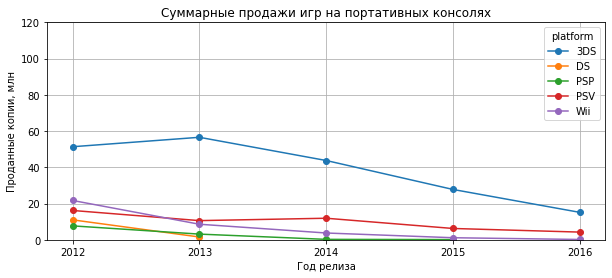

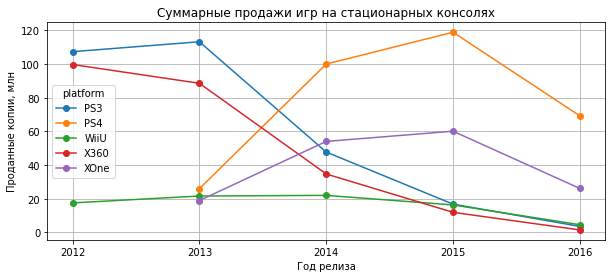

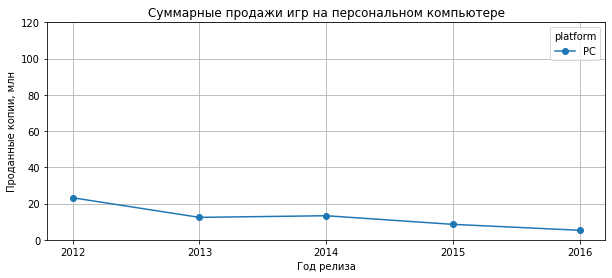

In [27]:
df_actual.query('platform_type == "Портативная консоль"')\
.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')\
.plot(style='o-', figsize=(10,4), grid=True, ylim=(0,120), xticks=(np.arange(2012, 2016+1, 1)),\
title='Суммарные продажи игр на портативных консолях', ylabel='Проданные копии, млн', xlabel='Год релиза')

df_actual.query('platform_type == "Стационарная консоль"')\
.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')\
.plot(style='o-', figsize=(10,4), grid=True, xticks=(np.arange(2012, 2016+1, 1)),\
title='Суммарные продажи игр на стационарных консолях', ylabel='Проданные копии, млн', xlabel='Год релиза')

df_actual.query('platform_type == "ПК"')\
.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')\
.plot(style='o-', figsize=(10,4), grid=True, ylim=(0,120), xticks=(np.arange(2012, 2016+1, 1)),\
title='Суммарные продажи игр на персональном компьютере', ylabel='Проданные копии, млн', xlabel='Год релиза')


plt.show();

Какие выводы можно сделать, смотря на эти графики:
* В последние годы популярность портативных консолей неумолимо снижается, самыми популярными остаются от производителя Nintendo (3DS, Wii);
* У стационарных консолей самые большие продажи игр на пике у более крупных производителей, такие так Sony (PS) и Microsoft (Xbox);
* Игры на персональном компьютере не имеют таких высоких продаж, зато они стабильные.

Резюмируя вышесказанное, самое перспективное делать игры на персональные компьютеры (стабильность, минимум рисков), а также на консоли крупных производителей, которые вышли недавно, за последние 2-3 года (PS4, XOne). Из портативных платформ самые высокие продажи у консоли 3DS. Еще можно понаблюдать за анонсами компании Nintendo. Как правило, ее консоли самые популярные

#### Диаграмма размаха продаж в разрезе игровых платформ (боксплот)

Построим боксплоты по глобальным продажам игр по разным платформам.

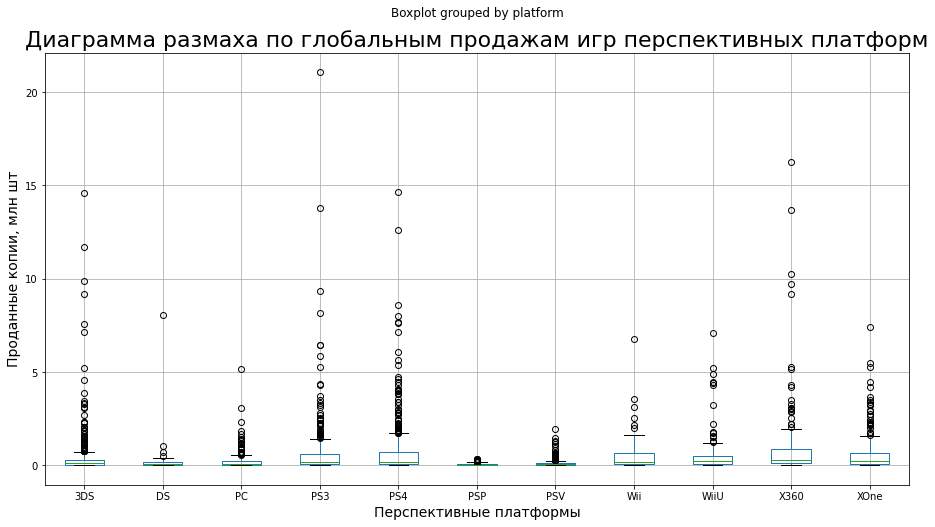

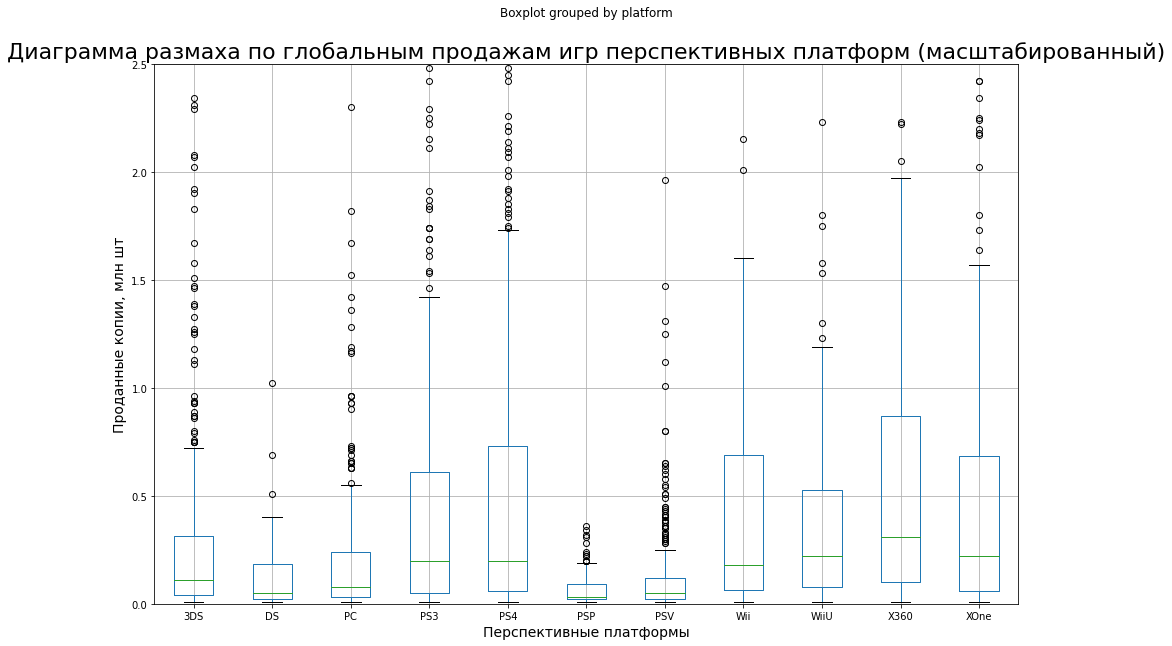

In [28]:
# Строим боксплот
df_actual.boxplot(column='total_sales', by='platform', figsize=(15,8))


plt.ylabel('Проданные копии, млн шт', fontsize=14)
plt.xlabel('Перспективные платформы', fontsize=14)
plt.title('Диаграмма размаха по глобальным продажам игр перспективных платформ', fontsize=22)
plt.show();

df_actual.boxplot(column='total_sales', by='platform', figsize=(15,10))
plt.ylim(0,2.5)
plt.ylabel('Проданные копии, млн шт', fontsize=14)
plt.xlabel('Перспективные платформы', fontsize=14)
plt.title('Диаграмма размаха по глобальным продажам игр перспективных платформ (масштабированный)', fontsize=22)
plt.show();

На графике видно, что у игр достаточно много выбросов. Возможно многие игры так и не добиваются популярности, а некоторые "выстреливают" и окупают не только себя, но и другие игры компаний.

Самые серьезные выбросы у тех платформ, которые имели максимальные продажи по годам (3DS, PS3, PS4), а также Xbox360. 
Вообще Xbox360 выглядит самой привлекательной платформой на боксплоте: У него самые высокие значения медианы и верхнего квартиля, а также межквартильный размах. Однако стоит понимать, что это старая модель консоли, на смену которой компания Miscosoft в 2013 году выпустила Xbox One.

#### Анализ продаж в зависимости от отзывов пользователей и критиков

Посмотрим, как влияют на продажи внутри популярных платформы отзывы пользователей и критиков. Возьмем одну из популярных платформ, а именно PS4.

<AxesSubplot:title={'center':'Зависимость глобальных продаж от оценок пользователей на платформе PS4'}, xlabel='Оценка пользователей', ylabel='Глобальные продажи, млн копий'>

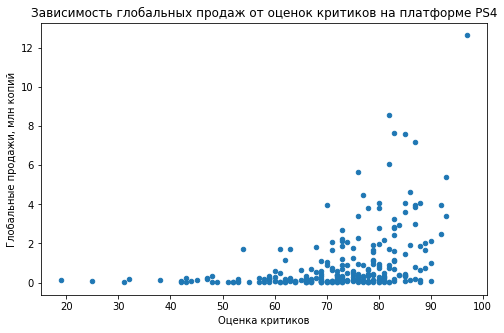

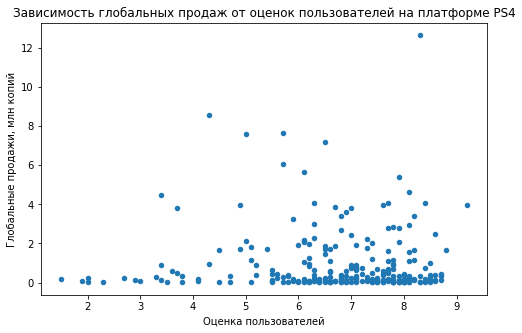

In [29]:
# Запосим перспективные платформы в список
top_actual_platforms = ['3DS', 'PS4', 'XOne', 'PC']

df_actual.query('platform == "PS4"')\
.plot(x='critic_score', y='total_sales', kind='scatter',\
figsize=(8,5), title='Зависимость глобальных продаж от оценок критиков на платформе PS4',\
xlabel='Оценка критиков', ylabel='Глобальные продажи, млн копий')

df_actual.query('platform == "PS4"')\
.plot(x='user_score', y='total_sales', kind='scatter',\
figsize=(8,5), title='Зависимость глобальных продаж от оценок пользователей на платформе PS4',\
xlabel='Оценка пользователей', ylabel='Глобальные продажи, млн копий')

In [30]:
# Считаем корреляцию
df_actual.loc[df['platform']== 'PS4', ['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


Действительно, все игры с высокими продажами как правило имеют высокие оценки критиков. Однако мы не можем утверждать о линейной зависимости между этими двумя параметрами. Коэффициент корреляции подтверждает это, связь между оценкой критиков и прожадами - средняя.

Связь между глобальными продажами и оценкой пользователей очень слабая.

Построим такие же диаграммы рассеивания для трех других популярных консолей.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


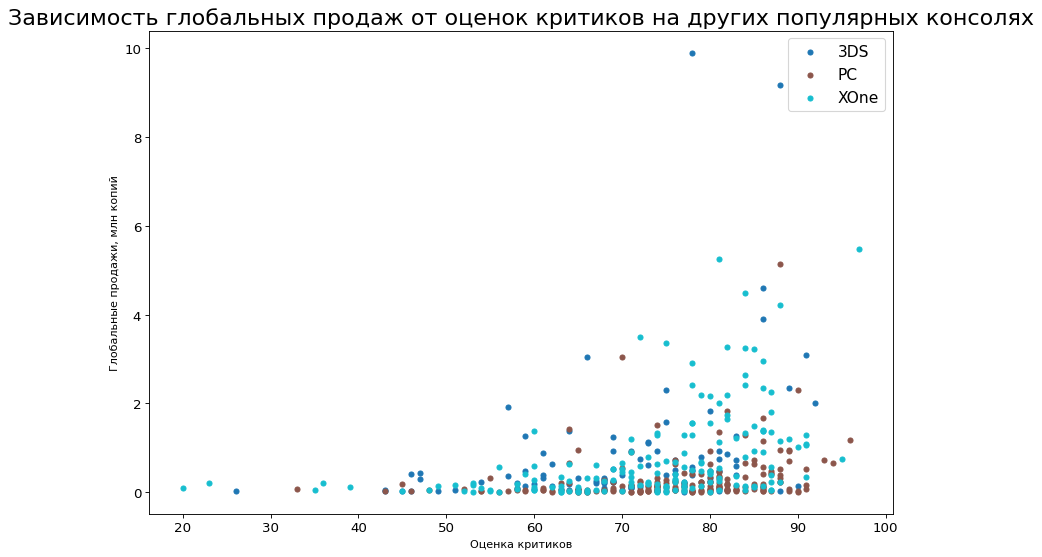

In [31]:
# Подготовка датасета
ax = df_actual.query('platform in @top_actual_platforms & platform != "PS4" & critic_score.notnull()')

# Создаем отдельный цвет для каждой платформы
categories = np.unique(ax['platform'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Рисуем график
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('critic_score', 'total_sales', 
                data=ax.loc[ax['platform']==category, :], 
                s=20, c=colors[i], label=str(category))
    
plt.gca().set(xlabel='Оценка критиков', ylabel='Глобальные продажи, млн копий')

# Настройки графика
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Зависимость глобальных продаж от оценок критиков на других популярных консолях", fontsize=20)
plt.legend(fontsize=14)    
plt.show();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


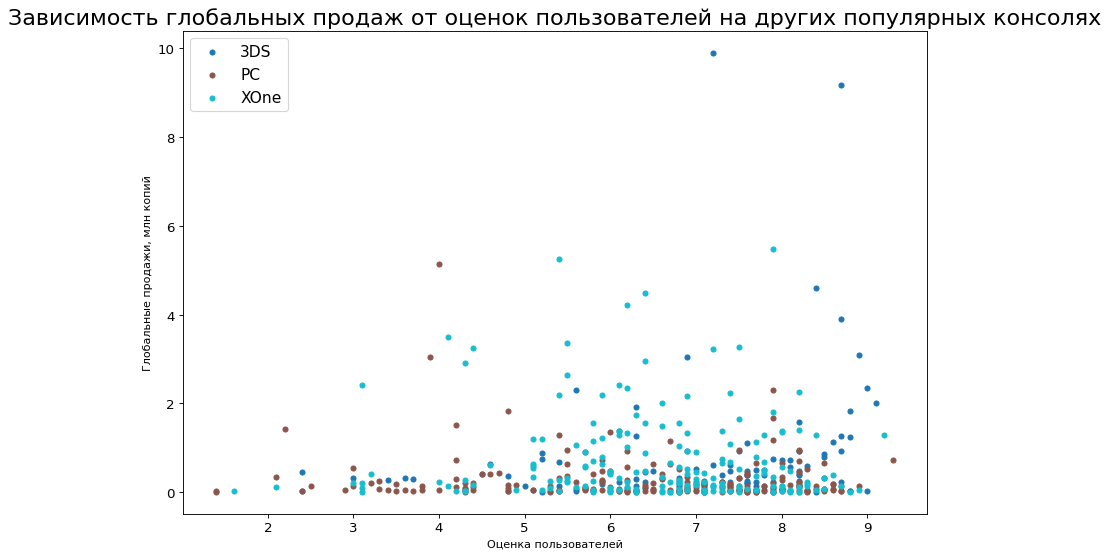

In [32]:
# Подготовка датасета
ax = df_actual.query('platform in @top_actual_platforms & platform != "PS4" & user_score.notnull()')

# Создаем отдельный цвет для каждой платформы
categories = np.unique(ax['platform'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Рисуем график
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('user_score', 'total_sales', 
                data=ax.loc[ax['platform']==category, :], 
                s=20, c=colors[i], label=str(category))
    
plt.gca().set(xlabel='Оценка пользователей', ylabel='Глобальные продажи, млн копий')

# Настройки графика
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Зависимость глобальных продаж от оценок пользователей на других популярных консолях", fontsize=20)
plt.legend(fontsize=14)    
plt.show();

Как показывают графики, на других популярных платформах ситуация аналогична.

Проверим корреляцию.

In [33]:
# Считаем корреляцию для 3DS
df_actual.loc[df['platform']== '3DS', ['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.320803,0.197583
critic_score,0.320803,1.000000,0.722762
user_score,0.197583,0.722762,1.000000


In [34]:
# Считаем корреляцию для PC
df_actual.loc[df['platform']== 'PC', ['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.237243,-0.121867
critic_score,0.237243,1.000000,0.432587
user_score,-0.121867,0.432587,1.000000


In [35]:
# Считаем корреляцию для XOne
df_actual.loc[df['platform']== 'XOne', ['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


Значение коэффициента корреляции незначительно, связь между оценкой критиков и продажами слабая, а между оценкой пользователей и продажами - очень слабая.

#### Анализ игр по жанрам

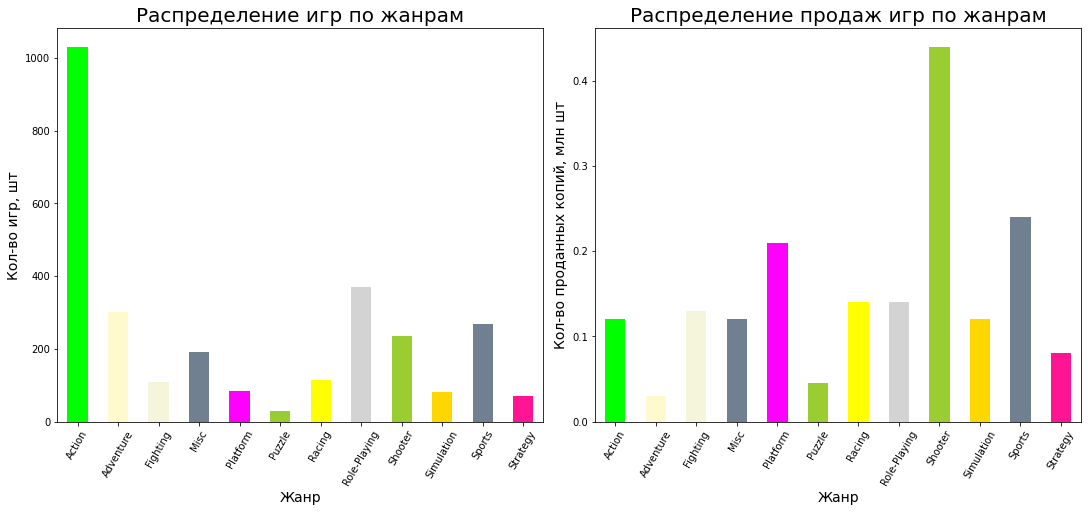

In [36]:
# Предварительные настройки для графиков
fg = plt.figure(figsize=(15, 7), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
all_colors = list(plt.cm.colors.cnames.keys())
c = random.choices(all_colors, k=df_actual['genre'].unique().__len__()+1)

# Распределение игр по жанрам
fig_ax_1 = fg.add_subplot(gs[0, 0])
ax_1 = df_actual.groupby('genre')['name'].count().plot(kind='bar', color=c)

# Настройки графика
# plt.bar_label(ax_1.containers[0])
plt.title('Распределение игр по жанрам', fontsize=20)
plt.xlabel('Жанр', fontsize=14)
plt.xticks(rotation=60)
plt.ylabel('Кол-во игр, шт', fontsize=14)


# Распределение полных продаж по жанрам
fig_ax_2 = fg.add_subplot(gs[0, 1])
ax_2 = df_actual.groupby('genre')['total_sales'].median().plot(kind='bar', color=c)

# Настройки графика
# plt.bar_label(ax_2.containers[0])
plt.title('Распределение продаж игр по жанрам', fontsize=20)
plt.xlabel('Жанр', fontsize=14)
plt.xticks(rotation=60)
plt.ylabel('Кол-во проданных копий, млн шт', fontsize=14)
plt.show();

Поделим количество проданных копий игр разных жанров на их количество, чтобы определить самый популярный.

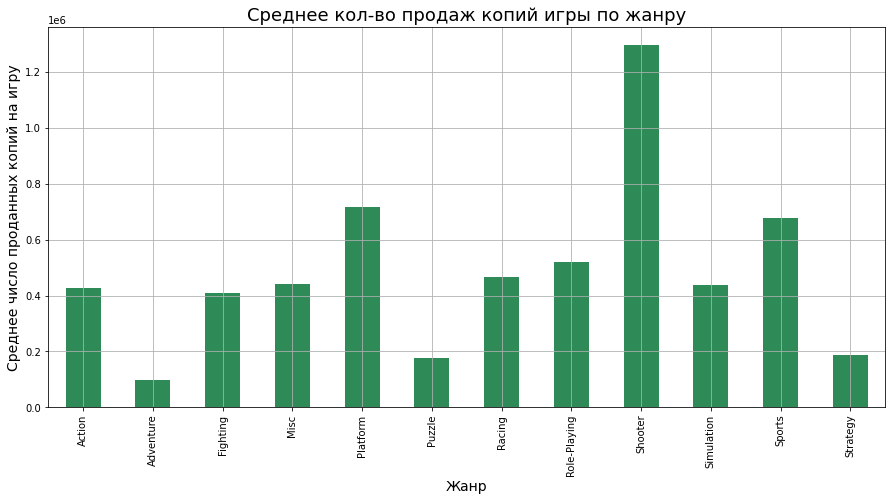

In [37]:
# Подготавливаем таблицу для графика
genre_group = df_actual.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count']).reset_index()
genre_group.columns = ['genre', 'total_sales', 'games_quantity']
genre_group['popular'] = genre_group['total_sales'] * 1000000 / genre_group['games_quantity']

# Строим график
genre_group.plot(kind='bar', x='genre', y='popular', color='seagreen', figsize=(15, 7), grid=True, legend=False)

plt.title('Среднее кол-во продаж копий игры по жанру', fontsize=18)
plt.xlabel('Жанр', fontsize=14)
plt.ylabel('Среднее число проданных копий на игру', fontsize=14)
plt.show();

Больше всего игр выпускается в жанре Action, однако его медианные продажи невысоки. Вероятно, многие игры так и не добиваются популярности.
Самые высокие продажи у жанра Scooter.
Наименее популярный жанр - Adventures. Хоть он и занимает 3-е место по количество игр, однако медианные продажи у него самые низкие.

Топ-3 популярных жанров - Shooter, Platform, Sports.

Чтобы изучить стабильность жанров, построим диаграмму размаха.

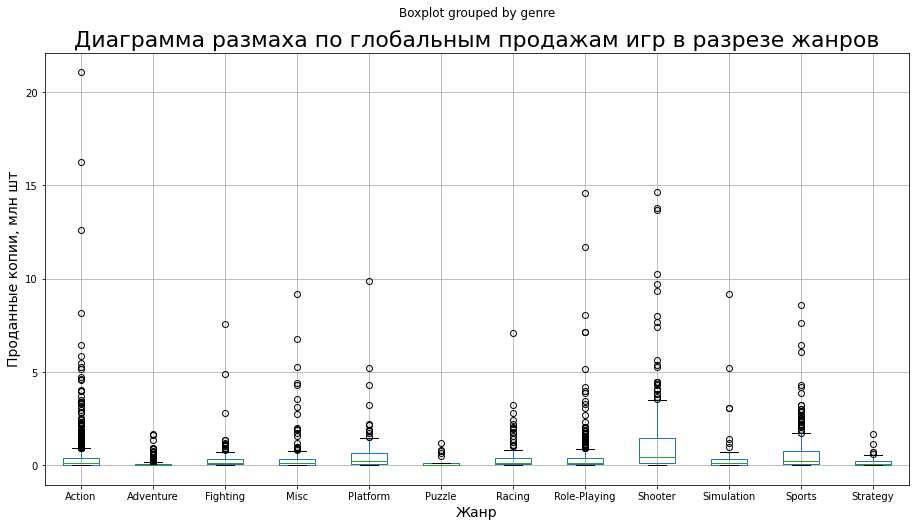

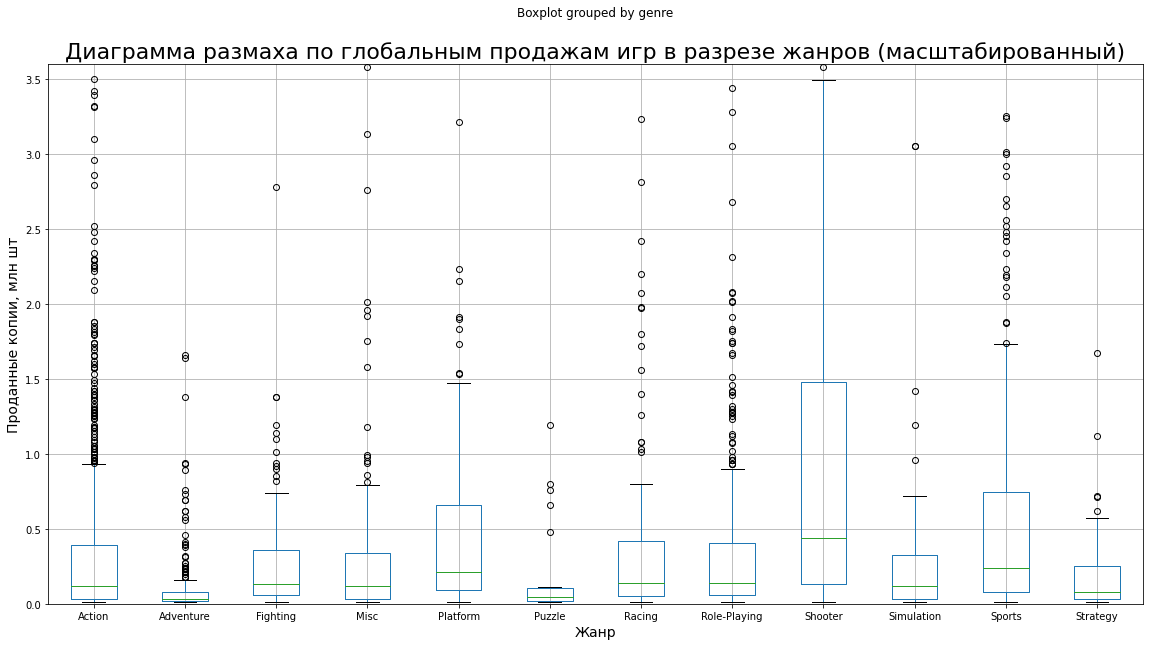

In [38]:
# Строим боксплот
df_actual.boxplot(column='total_sales', by='genre', figsize=(15,8))


plt.ylabel('Проданные копии, млн шт', fontsize=14)
plt.xlabel('Жанр', fontsize=14)
plt.title('Диаграмма размаха по глобальным продажам игр в разрезе жанров', fontsize=22)
plt.show();

df_actual.boxplot(column='total_sales', by='genre', figsize=(19,10))
plt.ylim(0,3.6)
plt.ylabel('Проданные копии, млн шт', fontsize=14)
plt.xlabel('Жанр', fontsize=14)
plt.title('Диаграмма размаха по глобальным продажам игр в разрезе жанров (масштабированный)', fontsize=22)
plt.show();

Жанры Shooter, Platform, Sports имеют самую высокую медиану продаж и межквартильный размах.

Также привлекательны жанры Simulation, Racing и Platform - у них не так много серьезных выбросов и шире интерквантильный интервал.

### Составление портрета пользователя каждого региона

#### Топ-5 популярных платформ по регионам

In [39]:
# Созданим листы топ-5 платформ по регионам
na_top_platform = df_actual.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head().reset_index()['platform'].tolist()
eu_top_platform = df_actual.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head().reset_index()['platform'].tolist()
jp_top_platform = df_actual.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head().reset_index()['platform'].tolist()

# Создадим новые столбцы, в которых все жанры, не вошедшие в топ-5, попадут в категорию Другие
df_actual['na_platform'] = df_actual['platform'].where(df['platform'].isin(na_top_platform), 'Other')
df_actual['eu_platform'] = df_actual['platform'].where(df['platform'].isin(eu_top_platform), 'Other')
df_actual['jp_platform'] = df_actual['platform'].where(df['platform'].isin(jp_top_platform), 'Other')

                                            Топ-5 популярных платформ по регионам                                            


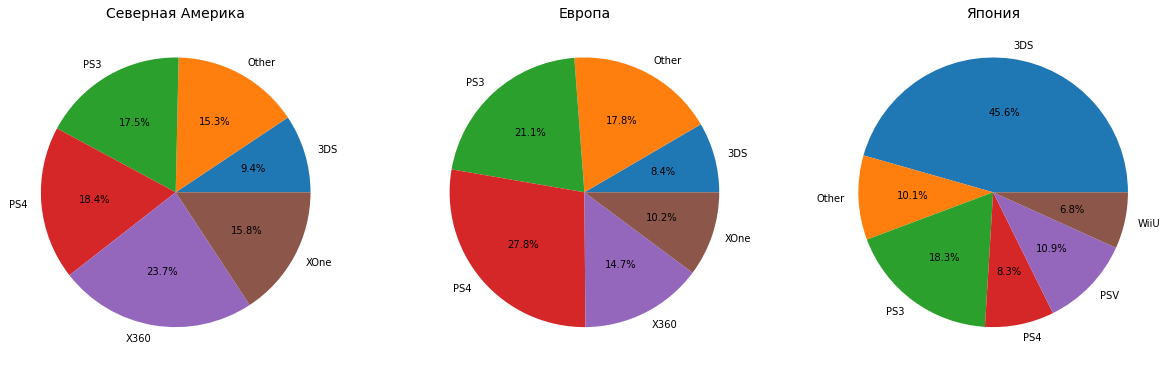

In [40]:
# Предварительные настройки для графиков
fg = plt.figure(figsize=(17,5), constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fg)

print('Топ-5 популярных платформ по регионам'.center(125))

# График по Северной Америке
fig_ax_1 = fg.add_subplot(gs[0, 0])
ax_1 = df_actual.groupby('na_platform')['na_sales'].sum().plot(kind='pie', autopct='%.1f%%')


plt.title('Северная Америка', fontsize=14)
plt.xlabel('')
plt.ylabel('')

# График по Европе
fig_ax_2 = fg.add_subplot(gs[0, 1])
ax_1 = df_actual.groupby('eu_platform')['eu_sales'].sum().plot(kind='pie', autopct='%.1f%%')

plt.title('Европа', fontsize=14)
plt.xlabel('')
plt.ylabel('')

# График по Японии
fig_ax_3 = fg.add_subplot(gs[0, 2])
ax_1 = df_actual.groupby('jp_platform')['jp_sales'].sum().plot(kind='pie', autopct='%.1f%%')

plt.title('Япония', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.show();

В топе игроков Серевной Америки и Европы одинаковые платформы - по 2 производсва Sony и Microsoft и одна портативная консоль компании Nintendo. В этом нет ничего удивительного, ведь эти консоли - лидеры на рынке.

Японские игроки намного чаще предпочитают играть в портативные консоли (их в топе 3 штуки). Также весь их топ состоит из консолей японских производителей (Sony и Nintendo)

#### Топ-5 популярных жанров по регионам

Построим такие же графики, но по игровым жанрам.

In [41]:
# Созданим листы топ-5 жанров по регионам
na_top_genre = df_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head().reset_index()['genre'].tolist()
eu_top_genre = df_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head().reset_index()['genre'].tolist()
jp_top_genre = df_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head().reset_index()['genre'].tolist()

# Создадим новые столбцы, в которых все жанры, не вошедшие в топ-5, попадут в категорию Другие
df_actual['na_genre'] = df_actual['genre'].where(df['genre'].isin(na_top_genre), 'Other')
df_actual['eu_genre'] = df_actual['genre'].where(df['genre'].isin(eu_top_genre), 'Other')
df_actual['jp_genre'] = df_actual['genre'].where(df['genre'].isin(jp_top_genre), 'Other')

                                             Топ-5 популярных жанров по регионам                                             


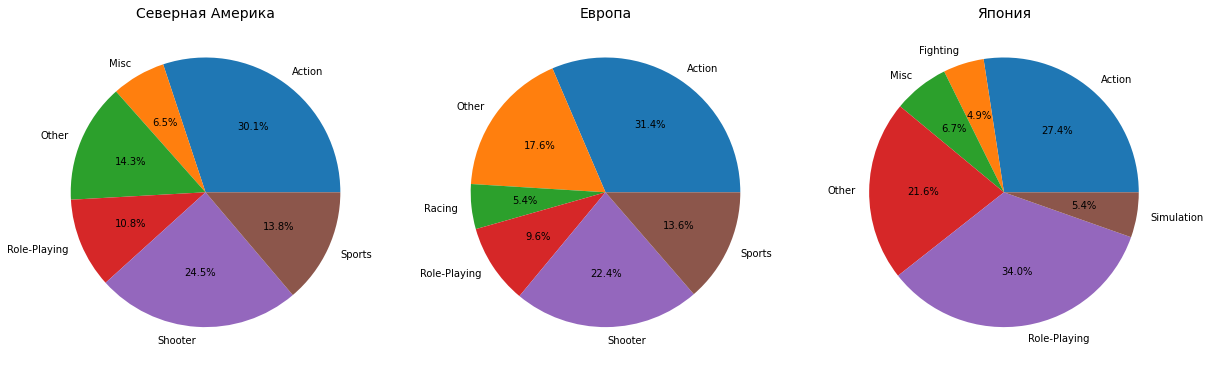

In [42]:
# Предварительные настройки для графиков
fg = plt.figure(figsize=(17,5), constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fg)

print('Топ-5 популярных жанров по регионам'.center(125))

# График по Северной Америке
fig_ax_1 = fg.add_subplot(gs[0, 0])
ax_1 = df_actual.groupby('na_genre')['na_sales'].sum().plot(kind='pie', autopct='%.1f%%')


plt.title('Северная Америка', fontsize=14)
plt.xlabel('')
plt.ylabel('')

# График по Европе
fig_ax_2 = fg.add_subplot(gs[0, 1])
ax_1 = df_actual.groupby('eu_genre')['eu_sales'].sum().plot(kind='pie', autopct='%.1f%%')

plt.title('Европа', fontsize=14)
plt.xlabel('')
plt.ylabel('')

# График по Японии
fig_ax_3 = fg.add_subplot(gs[0, 2])
ax_1 = df_actual.groupby('jp_genre')['jp_sales'].sum().plot(kind='pie', autopct='%.1f%%')

plt.title('Япония', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.show();

Здесь вкусы игроков Северной Америки и Европы практически совпадают. Только последний жанр в топ-5 отличается.
Японские игроки больше всего людят играть в жанр Role-Playing (еще бы, это же визуальные новеллы!), Action ушел на второе место.

#### Влияние рейтинга ESRB на продажи в отдельном регионе

Построим на графике распределение продаж в разных регионах по рейтингам игр.

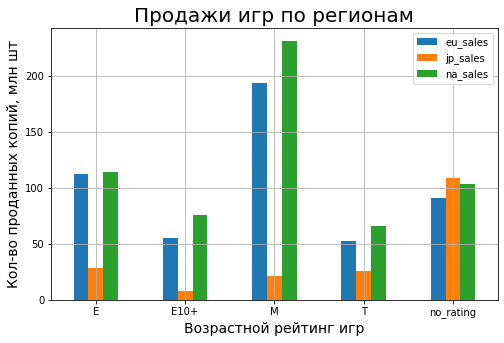

In [43]:
df_actual.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')\
.plot(kind='bar', grid=True, figsize=(8,5))

plt.title('Продажи игр по регионам', fontsize=20)
plt.xticks(rotation=0)
plt.xlabel('Возрастной рейтинг игр', fontsize=14)
plt.ylabel('Кол-во проданных копий, млн шт', fontsize=14)
plt.show();

Огромную часть продаж в Японии занимают игры без рейтинга ESRB. Вероятно, многи японские игры выпускаются исключительно для внутреннего рынка.

В Европе и Северной Америке самым популярным возрастным рейтингом является M.

### Проверка гипотез

Необходимо проверить 2 гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Проверка статистической гипотезы начинается с формулировки нулевой гипотезы. Она всегда формируется так, чтобы использовать знак равенства. Исходя из нулевой, формируется альтернативная гипотеза. Это утверждение, которое принимается верным, если отбрасывается нулевая гипотеза. Так как при проверке 2-х наших гипотез есть возможное отклонение как в большую, так и в меньшую сторону, альтернативная гипотеза является двусторонней.

При проверке наших гипотез мы сравниваем между собой средние рейтинги пользователей на разных платформах или разных жанров (т.е. две выборки двух генеральных совокупностей). При проверке таких гипотез используется  t-test. А в Python существует специальный метод scipy.stats.ttest_ind()

Уровень статистической значимости берем один из самых популярных - 5%

#### Проверка гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформируем нулевую (H0) и альтернативную (H1) гипотезы.

```
H0: Пользовательский рейтинг (user_score) платформы Xbox One = пользовательскому рейтингу (user_score) PC
Н1: Пользовательский рейтинг (user_score) платформы Xbox One ≠ пользовательскому рейтингу (user_score) PC
alpha = 0.05
```

In [44]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(\
                       df_actual[(df_actual['platform'] == 'XOne') & (df_actual['user_score'].notnull())]['user_score'], \
                       df_actual[(df_actual['platform'] == 'PC') & (df_actual['user_score'].notnull())]['user_score'], \
                      equal_var=False)

# alpha = значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


In [45]:
# Выведем средние пользовательские рейтинги платформ Xbox One и PC в качестве дополнительной проверки
df_actual.query('platform in ["XOne", "PC"]').groupby('platform').mean()['user_score']

platform
PC      6.428641
XOne    6.521429
Name: user_score, dtype: float64

#### Проверка гипотезы: Средние пользовательские рейтинги жанров Action и Sports разные.

```
H0: Пользовательский рейтинг (user_score) жанра Action = пользовательскому рейтингу (user_score) жанра Sports
Н1: Пользовательский рейтинг (user_score) жанра Action ≠ пользовательскому рейтингу (user_score) жанра Sports
alpha = 0.05
```

In [46]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(\
                       df_actual[(df_actual['genre'] == 'Action') & (df_actual['user_score'].notnull())]['user_score'], \
                       df_actual[(df_actual['genre'] == 'Sports') & (df_actual['user_score'].notnull())]['user_score'], \
                      equal_var=False)

# alpha = значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран
print(1 - results.pvalue)

# условный оператор с выводом строки с ответом
if (results.pvalue) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.0
Отвергаем нулевую гипотезу


In [47]:
# Выведем средние пользовательские рейтинги жанров Action и Sports в качестве дополнительной проверки
df_actual.query('genre in ["Action", "Sports"]').groupby('genre').mean()['user_score']

genre
Action    6.825048
Sports    5.455897
Name: user_score, dtype: float64

### Вывод

Мы проанализировали мировые продажи компьютерных игр интернет-магазина «Стримчик» для определения закономерностей, определяющие успешность игры.

**Предобработка данных**

В процессе предобработки датасета выявлены пропуски в данных. Восстановить их не удалось, поэтому часть пропусков (имя и жанр игры, год релиза) была удалена из датасета, часть (оценки пользователей и критиков, возрастной рейтинг) оставлены, чтобы не лишаться большого объема данных.

**Исследовательский анализ данных**

Мы определили, что любая модель консоли живет в среднем около 10 лет. При появлении новых моделей (в т.ч. от того же производителя) их продажи начинают падать.

Для дальнейшего исследования использовались данные за период 2012-2016 гг. Ввиду изменчивости игровой индустрии исследование более длинного промежутка может привести к некорректным выводам. 

Анализируя продажи игр на различных консолях, можно сделать следующие выводы:

- Самые популярные производители консолей – компании Sony, Microsoft и Nintendo (последняя преимущественно для японского рынка)
- Популярной ручных(портативных) консолей снижается
- Продажи игр на персональные компьютеры намного ниже популярных консолей (до 6 раз), зато они стабильные на протяжении многих лет.
- У игр, независимо от платформы часто не добиваются популярности, а отдельные «выстреливают» на высокие продажи, таким образом окупая не только себя, но и другие продукты производителя.

Таким образом, перспективно делать игры на персональные компьютеры, а также консоли крупных производителей, которые вышли не позднее, чем 3-4 года назад (PS4, Xbox One). Из портативных платформ самые высокие продажи у консоли 3DS компании Nintendo.

Анализ оценок пользователей и критиков показал, что, как правило, игры с высокими продажами имеют высокие оценки критиков. Однако линейной зависимости между этими параметрами не установлена. Оценки пользователей более разрозненны и с продажами мало связаны.

Анализ жанров выявил, что больше всего игр выпускается в жанре Action. Топ-3 самых популярных жанров – Shooter, Platform и Sports. При составлении портрета пользователя каждого анализируемого региона (Северная Америка, Европа и Япония) согласно полученным данным, пользователи Северной Америки и Европы имеют много общего. В их топ-5 входят одинаковые платформы, а также им нравятся практически одни и те же жанры игр (Action, Shooter, Sports, Role-Playing). В Европе и Северной Америке самым популярным возрастным рейтингом является M.

Японские пользователи отличаются намного сильнее. Они чаще играют в портативных консоли, а в их топ-5 состоит из консолей японских производителей (Sony и Nintendo). Топ их жанров открывает Role-Playing, также в нем Action, Misc, Simulation и Fighting. Более того, огромную часть продаж в Японии занимают игры без рейтинга ESRB (т.е. выпущенные не в Северно-Американском регионе). 

Также при исследовании были проверены две гипотезы о равенстве пользовательских оценок 2-х платформ (Xbox One и PC) и 2-х жанров (Action и Sports). В результате их проверки при помощи t-теста первую гипотезу не удалось опровергнуть. А вторая была отвергнута в пользу альтернативной, которая гласит, что пользовательские оценки жанров Action и Sports не равны между собой.


Резюмируя вышесказанное, после анализа продаж компьютерных игра за 2012-2016 гг рекомендуемые характеристики игр для рекламной компании следующие:
* Выходящие на современных платформах (PS4, Xbox One);
* В жанрах Shooter, Platform и Sports;
* Возрастным рейтингом М (если игра маркируется ESRB);
* Лучшие регионы для рекламы – Северная Америка и Европа.

При этом пользовательские оценки не являются решающим фактором, т.к. линейная связь между ними и продажа и игр очень слабая. Оценки критиков немного выше связаны с объемом продаж, но линейная связь между этими параметрами все еще слаба.


